# Text analysis
## Requisites
Done in python as several libraries are good enough for the text analysis, or even better than in R.
- Data scraping: `twint`
- Data management: `pandas`
  - https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html
- Text processing and sentiment analysis: `nltk`
  - Look at VADER for the sentiment analysis: `nltk.sentiment.vader.SentimentIntensityAnalyzer`
- Plotting: `seaborn` (or the built-in pandas graphs)
- Topic analysis: `corextopic`
  - <a href='https://github.com/gregversteeg/corex_topic'>Github repo</a>

## Steps
1. Scrape tweets
2. Import the data into pandas
3. Sentiment analysis
4. Process the text (e.g. tokenization, lemmatization, corpus, etc.)
5. Word cloud
6. Topic analysis
7. Combine both sentiment and topic analysis

## Visualizations functions

In [114]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def plot_wordcloud(tokens_list):
    plt.figure()
    mega_string = " ".join(" ".join(tokens) for tokens in tokens_list)
    wordcloud = WordCloud(background_color="white", max_words=10, stopwords=['harbor', 'port', 'harbour']).generate(mega_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## 1. Scrape tweets
Take into consideration that it can take around 1 hour to compile all of the tweets

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


file_name = f"./twitter_data_port.csv"

In [4]:
%%script false --no-raise-error
# https://github.com/twintproject/twint/wiki/Configuration
import twint

values_to_search = [
    "#ABPSouthampton",
    "#DP_World",
    "#GaPorts",
    "#PortofHamburg",
    "#HutchisonPPC",
    "#LondonPortAuth",
    "#PANYNJ",
    "#portdebarcelona",
    "#PortMTL",
    "#Port_Houston",
    "#PortofAntwerp",
    "#felixstowe_port",
    "#portoflongbeach",
    "#PortofLA",
    "#PortofOakland",
    "#PortOfRotterdam",
    "#PortofSeattle",
    "#PortVancouver",
    "#Port_Zeebrugge",
    "#portodigenova",
    "#PuertoAlgeciras",
    "#PuertodeCtg",
    "#SCPorts",
    "#PortofVirginia",
    "#AutPortValencia"
]

value = ['"port" and "expansion"'] # both words should be included

value = ['port'] # only port

value = ['harbour']

c = twint.Config()
for value in values_to_search:
    # c.Limit = 1000
    file_name = f"./twitter_data_{value}.csv"
    c.Output = file_name
    c.Store_csv = True
    c.Search = value
    c.Filter_retweets = True
    c.Lang = "en"
    twint.run.Search(c)

## 2. Importing the data

In [5]:
import pandas as pd
twitter_data = pd.read_csv(file_name)
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69264 entries, 0 to 69263
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               69264 non-null  int64  
 1   conversation_id  69264 non-null  int64  
 2   created_at       69264 non-null  object 
 3   date             69264 non-null  object 
 4   time             69264 non-null  object 
 5   timezone         69264 non-null  int64  
 6   user_id          69264 non-null  int64  
 7   username         69264 non-null  object 
 8   name             69261 non-null  object 
 9   place            2011 non-null   object 
 10  tweet            69264 non-null  object 
 11  language         69264 non-null  object 
 12  mentions         69264 non-null  object 
 13  urls             69264 non-null  object 
 14  photos           69264 non-null  object 
 15  replies_count    69264 non-null  int64  
 16  retweets_count   69264 non-null  int64  
 17  likes_count 

As we have collected a few datasets, we can combine them into a single (massive) one if we want to.

A small example has been included for confirmation.

In [6]:
%%script false --no-raise-error
# Example
test_1 = pd.read_csv("./test_1.csv")
test_2 = pd.read_csv("./test_2.csv")
twitter_data = pd.concat([test_1, test_2]) # this way we don't get duplicate tweets
twitter_data.drop_duplicates(subset='id', inplace=True)
twitter_data.reset_index(drop=True, inplace=True)

In [7]:
# %%script false --no-raise-error
all_files = [
    "./all_hashtags.csv",
    "./twitter_data_harbor.csv",
    "./twitter_data_port.csv",
    "./mega_twitter_data_port.csv"
]

twitter_data = pd.read_csv(all_files[0])
for file in all_files:
    temp_data = pd.read_csv(file)
    twitter_data = pd.concat([twitter_data, temp_data]) # this way we don't get duplicate tweets
twitter_data.drop_duplicates(subset='id', inplace=True)
twitter_data.reset_index(drop=True, inplace=True)
print(f"Size of data: {len(twitter_data.index)}")

Size of data: 162382


In [8]:
import re

# Only take the columns that are interesting
reduced_twitter = twitter_data[
    # Only English tweets
    (twitter_data['language']=='en') &
    # Only original tweets, no retweets
    (twitter_data['retweet']==False)
]

# Reduce size by only taking tweets and id
columns_to_keep = pd.Series(['id', 'tweet'])
reduced_twitter = reduced_twitter[columns_to_keep]

# Clean tweets from hastags, mentions, etc.
regex_cleanup_strings = [
    # Remove links
    r"\S*https?:\S*",
    # Remove hashtags
    # "#([a-zA-Z0-9_]{1,50})",
    # Remove mentions
    r"(?:\@|https?\://)\S+"
]
reduced_twitter["clean_tweet"] = reduced_twitter["tweet"]
for reg_string in regex_cleanup_strings:
    reduced_twitter["clean_tweet"] = reduced_twitter["clean_tweet"].replace(reg_string, '', regex=True)

reduced_twitter.reset_index(drop=True,inplace=True)
print(f"Reduced size (i.e. removing by contecnt, language, etc){len(reduced_twitter.index)}")
reduced_twitter.head(10)

Reduced size (i.e. removing by contecnt, language, etc)118919


,id,tweet,clean_tweet
0,1492573501542313990,@arabnews @united4wildlife @EarthshotPrize @Ke...,#Expo2020Dubai was wonderful and seeing...
1,1492537612757872645,"Speaking of #DP_World, they are now collaborat...","Speaking of #DP_World, they are now collaborat..."
2,1492537610253836296,EarthShot winners and finalists got to promote...,EarthShot winners and finalists got to promote...
3,1492492122557145092,@JaniceC28477503 @CamillaTominey Speaking of #...,"Speaking of #DP_World, they are now collabor..."
4,1492490261347373062,@JaniceC28477503 @CamillaTominey EarthShot win...,EarthShot winners and finalists got to promo...
5,1492316180614467590,@DP_World @JudithNeile @tusk_org @expo2020duba...,Thank you #DP_World 💕. #Tusk is an amazing...
6,1492183718102016004,@MayhewCharlie @DP_World @EarthshotPrize @unit...,Yes thank you #DP_World for supporting t...
7,1491891910876749824,@KensingtonRoyal @EarthshotPrize @expo2020duba...,It is brilliant the winners and finalists ...
8,1488377369975222274,#DP_World signs agreement with another major t...,#DP_World signs agreement with another major t...
9,1487180213926699013,"Today, I visited the #DP_World Pavilion at #ex...","Today, I visited the #DP_World Pavilion at #ex..."


## Sentiment analysis
For sentiment analysis, VADER rates depending on the form of the word. Therefore, it should NOT be lemmatized or stemmed. For topic classification, it SHOULD be, as a bag-of-words is given.

In [9]:
# Sentiment analysis using VADER
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

sentiment_analysis = pd.DataFrame(sid.polarity_scores(clean_tweet) for clean_tweet in reduced_twitter["clean_tweet"])

processed_twitter = pd.concat([reduced_twitter,  sentiment_analysis], axis=1)
processed_twitter.sort_values(by=['pos'], ascending=False).head(10)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,id,tweet,clean_tweet,neg,neu,pos,compound
104017,1505619688499425282,@Landlorduh1 Enjoy 😊,Enjoy 😊,0.0,0.0,1.0,0.4939
18543,1501824047532941312,"@juliaioffe God, God","God, God",0.0,0.0,1.0,0.4939
41079,1498141957612195841,@americandog98 true,true,0.0,0.0,1.0,0.4215
115620,1505324095151476742,@Leslie_B68 Thanks,Thanks,0.0,0.0,1.0,0.4404
75476,1497253471745196042,@Keribaby106 Lolz,Lolz,0.0,0.0,1.0,0.5719
90564,1505925510152568833,Congratulations 🎉,Congratulations 🎉,0.0,0.0,1.0,0.5994
17968,1501890821473325061,Congrats @jemillerwbal !,Congrats !,0.0,0.0,1.0,0.5707
99391,1505720433232199682,@the_epic_war Great @chain_port @solster_fina...,Great,0.0,0.0,1.0,0.6249
41901,1498119330567016449,@TOYINSWEETSTEW Cute,Cute,0.0,0.0,1.0,0.4588
110821,1505461358770651140,@vnsgwr Cute.,Cute.,0.0,0.0,1.0,0.4588


### Absolute sentiment

In [10]:
import numpy as np
def absolute_sent(sent_list):
    max_index = np.argmax(np.array(sent_list))
    if max_index == 0:
        return 'negative'
    elif max_index == 1:
        return 'neutral'
    else:
        return 'positive'

processed_twitter["abs_sent"] = processed_twitter.apply(lambda sent: absolute_sent([sent['neg'], sent['neu'], sent['pos']]), axis=1)
processed_twitter.head()

,id,tweet,clean_tweet,neg,neu,pos,compound,abs_sent
0,1492573501542313990,@arabnews @united4wildlife @EarthshotPrize @Ke...,#Expo2020Dubai was wonderful and seeing...,0.092,0.534,0.373,0.9355,neutral
1,1492537612757872645,"Speaking of #DP_World, they are now collaborat...","Speaking of #DP_World, they are now collaborat...",0.131,0.766,0.102,-0.2023,neutral
2,1492537610253836296,EarthShot winners and finalists got to promote...,EarthShot winners and finalists got to promote...,0.000,0.749,0.251,0.6908,neutral
3,1492492122557145092,@JaniceC28477503 @CamillaTominey Speaking of #...,"Speaking of #DP_World, they are now collabor...",0.131,0.766,0.102,-0.2023,neutral
4,1492490261347373062,@JaniceC28477503 @CamillaTominey EarthShot win...,EarthShot winners and finalists got to promo...,0.000,0.749,0.251,0.6908,neutral


## Process the text (e.g. tokenization, lemmatization and stop-words)

In [11]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
import nltk

test_sentence = "This is a very random test sentence. Let's see what happens churches"
print(test_sentence)

def sentence_processing(sentence:str, printing:bool = False):
    # Tokenize
    tokens = nltk.tokenize.word_tokenize(sentence.lower())
    if printing: print(tokens)

    # Remove punctuation
    tokens = [token for token in tokens if token.isalnum()]
    if printing: print(tokens)

    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))  
    tokens = [w for w in tokens if not w in stop_words]
    if printing: print(tokens)

    # Lemmatice
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    if printing: print(tokens)

    # Stemming
    # stemmer = nltk.stem.SnowballStemmer("english")
    # tokens = [stemmer.stem(w) for w in tokens]
    # if printing: print(tokens)

    return tokens

sentence_processing(test_sentence, printing=True)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoniosanchezmartin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This is a very random test sentence. Let's see what happens churches
['this', 'is', 'a', 'very', 'random', 'test', 'sentence', '.', 'let', "'s", 'see', 'what', 'happens', 'churches']
['this', 'is', 'a', 'very', 'random', 'test', 'sentence', 'let', 'see', 'what', 'happens', 'churches']
['random', 'test', 'sentence', 'let', 'see', 'happens', 'churches']
['random', 'test', 'sentence', 'let', 'see', 'happens', 'church']


['random', 'test', 'sentence', 'let', 'see', 'happens', 'church']

In [12]:
# Actual tokenization using the custom-made function
processed_twitter["tokens"] = processed_twitter["clean_tweet"].apply(lambda sentence: sentence_processing(sentence))
processed_twitter.head(20)

,id,tweet,clean_tweet,neg,neu,pos,compound,abs_sent,tokens
0,1492573501542313990,@arabnews @united4wildlife @EarthshotPrize @Ke...,#Expo2020Dubai was wonderful and seeing...,0.092,0.534,0.373,0.9355,neutral,"[expo2020dubai, wonderful, seeing, princewilli..."
1,1492537612757872645,"Speaking of #DP_World, they are now collaborat...","Speaking of #DP_World, they are now collaborat...",0.131,0.766,0.102,-0.2023,neutral,"[speaking, collaborating, another, princewilli..."
2,1492537610253836296,EarthShot winners and finalists got to promote...,EarthShot winners and finalists got to promote...,0.000,0.749,0.251,0.6908,neutral,"[earthshot, winner, finalist, got, promote, wo..."
3,1492492122557145092,@JaniceC28477503 @CamillaTominey Speaking of #...,"Speaking of #DP_World, they are now collabor...",0.131,0.766,0.102,-0.2023,neutral,"[speaking, collaborating, another, princewilli..."
4,1492490261347373062,@JaniceC28477503 @CamillaTominey EarthShot win...,EarthShot winners and finalists got to promo...,0.000,0.749,0.251,0.6908,neutral,"[earthshot, winner, finalist, got, promote, wo..."
5,1492316180614467590,@DP_World @JudithNeile @tusk_org @expo2020duba...,Thank you #DP_World 💕. #Tusk is an amazing...,0.000,0.565,0.435,0.9274,neutral,"[thank, tusk, amazing, organisation, glad, joi..."
6,1492183718102016004,@MayhewCharlie @DP_World @EarthshotPrize @unit...,Yes thank you #DP_World for supporting t...,0.000,0.286,0.714,0.9325,positive,"[yes, thank, supporting, wonderful, charity, i..."
7,1491891910876749824,@KensingtonRoyal @EarthshotPrize @expo2020duba...,It is brilliant the winners and finalists ...,0.000,0.727,0.273,0.8402,neutral,"[brilliant, winner, finalist, getting, showcas..."
8,1488377369975222274,#DP_World signs agreement with another major t...,#DP_World signs agreement with another major t...,0.000,0.738,0.262,0.4939,neutral,"[sign, agreement, another, major, tenant, lond..."
9,1487180213926699013,"Today, I visited the #DP_World Pavilion at #ex...","Today, I visited the #DP_World Pavilion at #ex...",0.000,0.903,0.097,0.4767,neutral,"[today, visited, pavilion, expo2020dubai, dp, ..."


### Remove short tweets
Justification: Longer tweets will be easier to categorize (both sentiment and topic) and will be more likely to be an "opinion"

In [13]:
# Number of words column
at_least_num_words = 7

processed_twitter["num_tokens"] = processed_twitter["tokens"].apply(lambda tokens: len(tokens))
print(f"Rows before removing short tweets: {len(processed_twitter.index)}")
# Remove short tweets
processed_twitter.drop(processed_twitter[processed_twitter["num_tokens"] < at_least_num_words].index, inplace=True)
print(f"Rows after removing short tweets: {len(processed_twitter.index)}")

Rows before removing short tweets: 118919
Rows after removing short tweets: 92477


### Remove NaN

In [14]:
processed_twitter.dropna(how='any',inplace=True)
print(f"Rows after removing NaN: {len(processed_twitter.index)}")

Rows after removing NaN: 92477


### Optional: Remove certain topics by key tokens
If the tokens include the following words, they have to be removed. The words are also processed to make sure that they match with the tokens.

In [15]:
# %%script false --no-raise-error
# Linked tokens
processed_twitter["token_string"] = processed_twitter["tokens"].apply(lambda token_list: ' '.join(token_list))
processed_twitter.head()

# # Remove certain topics based on substrings
# to_remove = [
#     "Police", 
#     'videogame',
#     'game',
#     # 'cereal',
#     'USB',
#     'TRADE',
#     'BID',
#     'fromsoftware',
#     'Ukranian',
#     'russia',
#     'ukraine',
#     'offer',
#     'hdmi',
#     'vga',
#     'pearl'
# ]

to_remove = [
    "#pdx911", # the bloody portland police notifications
    "PRAYER"
]

to_remove = sentence_processing(' '.join(to_remove))

print(f"Size before cleanup: {len(processed_twitter.index)}")
for string in to_remove:
    processed_twitter = processed_twitter[~processed_twitter["token_string"].str.contains(string, case=False)]
processed_twitter.drop(labels=["token_string"], axis=1, inplace=True)
print(f"Size after cleanup: {len(processed_twitter.index)}")

Size before cleanup: 92477
Size after cleanup: 87758


### Optional: Only #portof
For more relevant data, only a subset of the tweets will be used.
These tweets must use `#portof...`, in any sort of capitalization

However, this results in a ridiculously small dataset, which is far from what we want.

In [16]:
%%script false --no-raise-error
print(f"Size before cleanup: {len(processed_twitter.index)}")
processed_twitter = processed_twitter[processed_twitter["clean_tweet"].str.contains("#portof", case=False)]
print(f"Size after cleanup: {len(processed_twitter.index)}")

In [17]:
processed_twitter.head()

,id,tweet,clean_tweet,neg,neu,pos,compound,abs_sent,tokens,num_tokens
0,1492573501542313990,@arabnews @united4wildlife @EarthshotPrize @Ke...,#Expo2020Dubai was wonderful and seeing...,0.092,0.534,0.373,0.9355,neutral,"[expo2020dubai, wonderful, seeing, princewilli...",21
1,1492537612757872645,"Speaking of #DP_World, they are now collaborat...","Speaking of #DP_World, they are now collaborat...",0.131,0.766,0.102,-0.2023,neutral,"[speaking, collaborating, another, princewilli...",12
2,1492537610253836296,EarthShot winners and finalists got to promote...,EarthShot winners and finalists got to promote...,0.000,0.749,0.251,0.6908,neutral,"[earthshot, winner, finalist, got, promote, wo...",10
3,1492492122557145092,@JaniceC28477503 @CamillaTominey Speaking of #...,"Speaking of #DP_World, they are now collabor...",0.131,0.766,0.102,-0.2023,neutral,"[speaking, collaborating, another, princewilli...",12
4,1492490261347373062,@JaniceC28477503 @CamillaTominey EarthShot win...,EarthShot winners and finalists got to promo...,0.000,0.749,0.251,0.6908,neutral,"[earthshot, winner, finalist, got, promote, wo...",10


## Topic categorization
First, the tokens need to be processed into a bag of words.
It is sparse (for storage) and `sklearn` does wonders for it (although it needs the tokens as a single string).

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

# Train the LDA
def topic_train(dataframe_in, num_topics=5, anchors = list(), summary_name = 'topic_class_summary', anchor_strength = 10):
    dataframe = dataframe_in.copy()
    # Obtain bag-of-words sparse matrix
    corpus = [' '.join(tokens) for tokens in dataframe["tokens"]] # tokens in each message
    vectorizer = CountVectorizer(analyzer='word', stop_words='english') # object to create the bag of words
    word_bag = vectorizer.fit_transform(corpus) # this is a sparse matrix!
    word_features = vectorizer.get_feature_names_out() # i.e. the actual word names
    ids = dataframe["id"].tolist() # list of all twitter ids; i.e. labelling of the rows of the matrix
    # Train the model
    topic_model = ct.Corex(n_hidden=num_topics)  # Define the number of latent (hidden) topics to use.
    if anchors:
        print("Anchors accepted. Hopefully")
        topic_model.fit(
            word_bag, 
            anchors=anchors,
            anchor_strength=anchor_strength, # i.e. how many more times the anchor weighs compared to normal words
            words=word_features, 
            docs=ids
        )
    else:
        print("No anchors? Sure")
        topic_model.fit(
            word_bag, 
            words=word_features, 
            docs=ids
        )
    # Export summary data
    vt.vis_rep(topic_model, column_label=word_features, prefix=summary_name)
    return topic_model

# Get the top words from a model
def topic_top_words(topic_model):
    # Get the terms for the topics
    topics = topic_model.get_topics()
    topic_list = list()
    for topic_n,topic in enumerate(topics):
        # w: word, mi: mutual information, s: sign
        topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
        # Unpack the info about the topic
        words,mis,signs = zip(*topic)    
        # Print topic
        topic_str = str(topic_n+1)+': '+', '.join(words)
        topic_list.append(topic_str)
    long_string = "\n".join(topic_list)
    print(long_string)
    return long_string

# Plot the correlation score of each topic
import matplotlib.pyplot as plt
def topic_correlation_plot(topic_model):
    plt.bar(range(1, topic_model.tcs.shape[0]+1), topic_model.tcs, color='#4e79a7')
    plt.xlabel('Topic')
    plt.grid('both')
    plt.ylabel('Total Correlation (nats)')
    plt.xticks(np.arange(1, topic_model.tcs.shape[0]+1, step=1))
    plt.show()


from typing import List
import numpy as np

def select_topics(dataframe_in, topic_model_array, selected_topics, drop_column=True, remove = False):
    df = dataframe_in.copy()
    df.reset_index(inplace=True, drop=True)
    indices = list()
    for topic in selected_topics:
        index_array = np.where(topic_model_array[:, topic] == True)
        indices.append(index_array[0].tolist())
    indices = [item for sublist in indices for item in sublist]
    indices = np.sort(np.array(indices))
    indices = indices.tolist()
    if remove:
        df = df.loc[~df.index.isin(indices)]
    else:
        df = df.loc[df.index.isin(indices)]
    if drop_column:
        df.drop(labels=["topic"], axis=1, inplace=True)
    df.reset_index(inplace=True, drop=True)
    return df


# Process the anchors exactly in the same way as the tweets themselves for creating the tokens
process_anchors = lambda anchors: [sentence_processing(' '.join(set)) for set in anchors]

# Get topic list
get_topic_list = lambda topic_model: pd.Series(topic_model.labels.tolist())


#### First LDA: Differenciate useful and useless tweets
Use an LDA with several topics to manually sift uninteresting results.
Save the results into a file so that it is not over-written every time.

In [19]:
# Create the list for comparison for several topics
%%script false --no-raise-error
keywords_per_topics = list()
for num in range(2, 11):
    topic_model = topic_train(processed_twitter, num_topics=num, summary_name = 'temp_classifier')
    keywords_per_topics.append(topic_top_words(topic_model))
np.savetxt("first_topic_keywords.csv", 
           keywords_per_topics,
           delimiter =", ", 
           fmt ='% s')

UsageError: Line magic function `%%script` not found.


In [20]:
# Train the LDA 
useful_topic_model = topic_train(processed_twitter, num_topics=10, summary_name = 'manual_split')

No anchors? Sure
Print topics in text file


In [21]:
print("They should be the same")
print(useful_topic_model.labels.shape)
print(len(processed_twitter.index))

They should be the same
(87758, 10)
87758


In [22]:
# Create the copy with the topics
useful_twitter = processed_twitter.copy()
useful_twitter.reset_index(inplace=True, drop=True)
useful_twitter['topic']=get_topic_list(useful_topic_model)

In [23]:
# Check for NaN values
useful_twitter['topic'].isna().sum() 

0

In [24]:
# Print the top words
topic_top_words(useful_topic_model)

1: russian, ukraine, russia, pearl, war, mariupol, ukrainian, putin, city, attack
2: mt, utc, detected, wind, threatintelligence, 8022, attempt, del, cbh, temp
3: usb, charging, charger, listing, laptop, cable, hdmi, adapter, outlet, protector
4: mar, 2022, high, march, basketball, tide, predicted, apply, low, pressure
5: service, pick, terminal, scheduled, depart, container, penn, shipping, cargo, logistics
6: like, think, make, know, really, thing, want, people, need, got
7: game, pc, na, switch, gon, console, elden, play, ring, remake
8: port, ~harbor, ~harbour, ~sydney, harcourt, ~safe, ~bridge, authority, ~liyue, ~crash
9: ~beautiful, ~wine, ~day, ~beach, ~lovely, ~walk, ~enjoy, ~birthday, ~morning, ~delicious
10: state, amp, member, law, nigeria, family, river, officer, lagos, united


'1: russian, ukraine, russia, pearl, war, mariupol, ukrainian, putin, city, attack\n2: mt, utc, detected, wind, threatintelligence, 8022, attempt, del, cbh, temp\n3: usb, charging, charger, listing, laptop, cable, hdmi, adapter, outlet, protector\n4: mar, 2022, high, march, basketball, tide, predicted, apply, low, pressure\n5: service, pick, terminal, scheduled, depart, container, penn, shipping, cargo, logistics\n6: like, think, make, know, really, thing, want, people, need, got\n7: game, pc, na, switch, gon, console, elden, play, ring, remake\n8: port, ~harbor, ~harbour, ~sydney, harcourt, ~safe, ~bridge, authority, ~liyue, ~crash\n9: ~beautiful, ~wine, ~day, ~beach, ~lovely, ~walk, ~enjoy, ~birthday, ~morning, ~delicious\n10: state, amp, member, law, nigeria, family, river, officer, lagos, united'

In [25]:
# See the topic correlation
topic_correlation_plot(useful_topic_model)

/var/folders/j_/fksmwvvx4_3168_scxg6_7hh0000gn/T/ipykernel_1091/3262725002.py:61: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [26]:
# Aaand drop the useless topics
useful_twitter_red = select_topics(useful_twitter, useful_topic_model.labels, [0, 1, 2, 3, 6, 9], remove=True, drop_column=False)
useful_twitter_red.head(5)

,id,tweet,clean_tweet,neg,neu,pos,compound,abs_sent,tokens,num_tokens,topic
0,1492316180614467590,@DP_World @JudithNeile @tusk_org @expo2020duba...,Thank you #DP_World 💕. #Tusk is an amazing...,0.000,0.565,0.435,0.9274,neutral,"[thank, tusk, amazing, organisation, glad, joi...",11,"[False, False, False, False, False, False, Fal..."
1,1497632785846132748,AIDAcosma makes first call to Port of Hamburg ...,AIDAcosma makes first call to Port of Hamburg ...,0.000,1.000,0.000,0.0000,neutral,"[aidacosma, make, first, call, port, hamburg, ...",13,"[False, False, False, False, True, False, Fals..."
2,907938387923009537,A great day to enjoy the river and the industr...,A great day to enjoy the river and the industr...,0.000,0.687,0.313,0.8074,neutral,"[great, day, enjoy, river, industry, estuary, ...",11,"[False, False, False, False, False, False, Fal..."
3,1487441728361713671,From. #PANYNJ Wva snowed out 0 entrance no way...,From. #PANYNJ Wva snowed out 0 entrance no way...,0.289,0.711,0.000,-0.6908,neutral,"[panynj, wva, snowed, 0, entrance, way, pa, mu...",11,"[False, False, False, False, False, False, Fal..."
4,1495872695858257920,"🥳 Good news for ship and ocean lovers, young a...","🥳 Good news for ship and ocean lovers, young a...",0.000,0.751,0.249,0.8061,neutral,"[good, news, ship, ocean, lover, young, old, a...",18,"[False, False, False, False, False, True, Fals..."


In [38]:
# Save the file so that it stays consistent
%%script false --no-raise-error
useful_twitter_red.to_csv('manual_topics.csv', index=False)

### Second LDA: Topic classification

In [40]:
# Load the stored data
import pandas as pd
useful_twitter = pd.read_csv('manual_topics.csv')
print(f"Size final dataset: {len(useful_twitter.index)}")

Size final dataset: 6188


In [29]:
# Anchor words
topic_anchors =[
    ['eConomy', 'PROFIT', 'internationals', 'infrastructure', 'business', 'company', 'relations', 'revenue','import', 'export'], # economy
    ['green', 'climate', 'emissions','CO2', 'sustainable', 'renewable', 'windmill', 'solar', 'hydrogen', 'battery', 'earth', 'environment', 'nature', 'wildlife', 'trees', 'circularity', 'climate change'], #sustainability
    ['city', 'work', 'jobs', 'labour', 'participation', 'livability', 'housing', 'commute', 'education', 'training', 'school', 'environment', 'tourist'] #people
]
topic_anchors = process_anchors(topic_anchors) # do the processing so it matches the actual tokens
print(topic_anchors)

[['economy', 'profit', 'international', 'infrastructure', 'business', 'company', 'relation', 'revenue', 'import', 'export'], ['green', 'climate', 'emission', 'co2', 'sustainable', 'renewable', 'windmill', 'solar', 'hydrogen', 'battery', 'earth', 'environment', 'nature', 'wildlife', 'tree', 'circularity', 'climate', 'change'], ['city', 'work', 'job', 'labour', 'participation', 'livability', 'housing', 'commute', 'education', 'training', 'school', 'environment', 'tourist']]


In [30]:
# Create the list for comparison for several topics
%%script false --no-raise-error
keywords_per_topics = list()
for num in range(3, 11):
    topic_model = topic_train(useful_twitter, num_topics=num, anchors=topic_anchors, summary_name = 'topic_classifier', anchor_strength=5)
    keywords_per_topics.append(topic_top_words(topic_model))
np.savetxt("second_topic_keywords.csv", 
           keywords_per_topics,
           delimiter =", ", 
           fmt ='% s')

Anchors accepted. Hopefully
Print topics in text file
1: company, business, international, port, ~harbour, charles, ~harbor, ~sydney, gh, like
2: change, nature, green, tree, earth, environment, ~mystery, changed, circular, au
3: city, work, school, job, environment, training, housing, labour, education, silent
Anchors accepted. Hopefully
Print topics in text file
1: company, business, international, smashwords, mystery, suspense, safe, free, today, economy
2: change, green, tree, newport, yacht, stolen, stealing, beach, crash, harbor
3: city, work, school, job, tourist, environment, housing, training, labour, commute
4: cruise, ~taylor, harbour, sydney, ~wine, ~delicious, vividsydney, vivid, ~na, ~hungry
Anchors accepted. Hopefully
Print topics in text file
1: company, business, international, leeds, owner, vegetable, peakyblinders, sunlight, supermarket, practice
2: change, nature, green, environment, spray, 100, richmond, overnight, renewable, battery
3: city, work, school, job, tou

In [31]:
topic_model = topic_train(useful_twitter, num_topics=5, anchors=topic_anchors, summary_name = 'topic_classifier', anchor_strength=10)

Anchors accepted. Hopefully
Print topics in text file


For determining the number of groups, the TC is plotted. In general, you choose a number of topics once the TC plateaus.

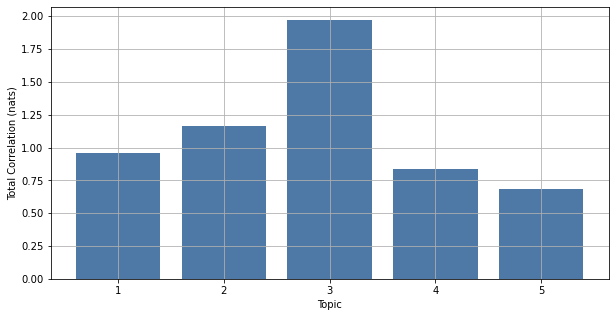

In [44]:
topic_correlation_plot(topic_model)

Some nice visualizations and summaries for the classification data.

In [45]:
topic_top_words(topic_model)

1: company, business, economy, export, relation, import, infrastructure, ~international, quay, spray
2: change, nature, tree, earth, newport, yacht, battery, renewable, stealing, stolen
3: city, work, school, job, tourist, environment, housing, training, labour, commute
4: harbor, ~game, free, ~pc, cruise, sydney, ~port, ~joss, vividsydney, ~really
5: mystery, smashwords, suspense, today, safe, ~local, ~painting, ~like, ~downtown, ~uk


'1: company, business, economy, export, relation, import, infrastructure, ~international, quay, spray\n2: change, nature, tree, earth, newport, yacht, battery, renewable, stealing, stolen\n3: city, work, school, job, tourist, environment, housing, training, labour, commute\n4: harbor, ~game, free, ~pc, cruise, sydney, ~port, ~joss, vividsydney, ~really\n5: mystery, smashwords, suspense, today, safe, ~local, ~painting, ~like, ~downtown, ~uk'

In [161]:
def all_false_remover(df_in, model):
    df = df_in.copy()
    false_list = [False for _ in range(model.labels.shape[1])]
    df['all_false'] = df['topic'].apply(lambda topic: True if topic == false_list else False)
    df = df.drop(df[df['all_false']==True].index)
    df.drop(['all_false'],axis=1,inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df
    
# Final dataframe
ppp_twitter = useful_twitter.copy()
ppp_twitter.reset_index(inplace=True, drop=True)
ppp_twitter['topic']=get_topic_list(topic_model)
ppp_twitter = select_topics(ppp_twitter, topic_model.labels, selected_topics=[3, 4], remove=True, drop_column=False)

def number_topic(topic, num_topics = 5):
    topic_dict = {
        1: "Profit",
        2: "Planet",
        3: "People",
    }
    list_of_lists = list()
    for topic_num in range(3):
        list_of_lists.append([False for _ in range(num_topics)])
        list_of_lists[topic_num][topic_num] = True
    for topic_num in range(3):
        if topic == list_of_lists[topic_num]:
            return topic_dict[topic_num+1]
    return "Combination"


# Remove "all false" topics (i.e. not belonging to anything)
ppp_twitter = all_false_remover(ppp_twitter, topic_model)
print(f"Final 3 topics tweets: {len(ppp_twitter.index)}")
ppp_twitter.head(20)

ppp_twitter['PPP'] = ppp_twitter['topic'].apply(number_topic)

ppp_twitter['pos'] = pd.to_numeric(ppp_twitter['pos'])
ppp_twitter['neg'] = pd.to_numeric(ppp_twitter['neg'])
ppp_twitter['neu'] = pd.to_numeric(ppp_twitter['neu'])

ppp_twitter.head(10)

Final 3 topics tweets: 340


,id,tweet,clean_tweet,neg,neu,pos,compound,abs_sent,tokens,num_tokens,topic,PPP
0,1503316852017025027,"They hurried through the town, pursued by thro...","They hurried through the town, pursued by thro...",0.116,0.826,0.058,-0.4215,neutral,"['hurried', 'town', 'pursued', 'throbbing', 's...",23.0,"[True, False, False, False, False]",Profit
1,1503248586166919168,@geo_wanderer someone sold this to you ?? [ h...,someone sold this to you ?? [ his eyes sudde...,0.154,0.750,0.096,-0.5514,neutral,"['someone', 'sold', 'eye', 'suddenly', 'glow',...",30.0,"[True, False, False, False, False]",Profit
2,1503212705062301699,"@CaenarLevia Hello, Adventurer! I see you are ...","Hello, Adventurer! I see you are a fan of the...",0.053,0.716,0.232,0.8588,neutral,"['hello', 'adventurer', 'see', 'fan', 'ocean',...",22.0,"[True, False, False, False, False]",Profit
3,1503186700520292352,"@RhodaPFem Unimpressed, to say the least. Bu...","Unimpressed, to say the least. But he now h...",0.064,0.936,0.000,-0.1779,neutral,"['unimpressed', 'say', 'least', 'little', 'pen...",16.0,"[False, True, False, False, False]",Planet
4,1503180733594046464,"Look us up...OXNARD, CA ..we sell these on the...","Look us up...OXNARD, CA ..we sell these on the...",0.000,0.820,0.180,0.8402,neutral,"['look', 'u', 'oxnard', 'ca', 'sell', 'side', ...",27.0,"[True, False, False, False, False]",Profit
5,1503164553517010947,Oak Harbor alum Andrea Cecil and her Florida G...,Oak Harbor alum Andrea Cecil and her Florida G...,0.000,1.000,0.000,0.0,neutral,"['oak', 'harbor', 'alum', 'andrea', 'cecil', '...",19.0,"[False, True, False, False, False]",Planet
6,1503131897693556738,"expression loosened, one more relaxed settling...","expression loosened, one more relaxed settling...",0.000,0.915,0.085,0.5341,neutral,"['expression', 'loosened', 'one', 'relaxed', '...",24.0,"[False, False, True, False, False]",People
7,1503116527834316801,@quoththewriter It sounds like you’re doing al...,It sounds like you’re doing all you can reall...,0.000,0.705,0.295,0.9173,neutral,"['sound', 'like', 'really', 'minimize', 'bubbl...",28.0,"[False, False, True, False, False]",People
8,1503105053351100423,@zeldafrench_ I found my first grey hair at 11...,I found my first grey hair at 11 but tbf I've...,0.063,0.714,0.223,0.9113,neutral,"['found', 'first', 'grey', 'hair', '11', 'tbf'...",29.0,"[True, False, False, False, False]",Profit
9,1503091517593821187,Annie didn’t hesitate to kill everyone in the ...,Annie didn’t hesitate to kill everyone in the ...,0.299,0.701,0.000,-0.9331,neutral,"['annie', 'hesitate', 'kill', 'everyone', 'har...",19.0,"[False, False, True, False, False]",People


Quick explanation of the important output files in folder:
- `labels.txt` -> To which group does each tweet belong
  - Similar to `topic_model.labels`
- `topics.txt` -> Top words of each topic

## Visualizations


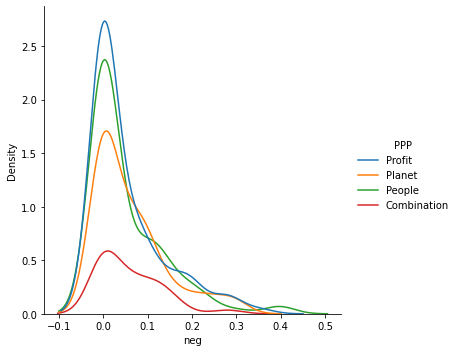

In [164]:
# Positive
import seaborn as sns
sns.displot(data=ppp_twitter, x="neg", hue='PPP', kind='kde')

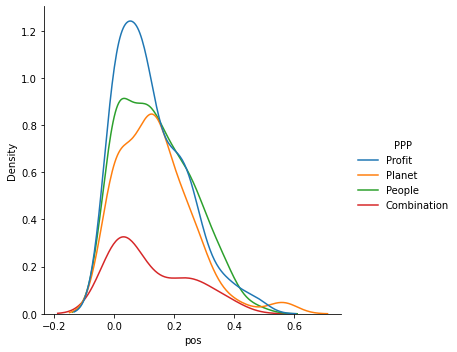

In [165]:
# Positive
sns.displot(data=ppp_twitter, x="pos", hue='PPP', kind='kde')

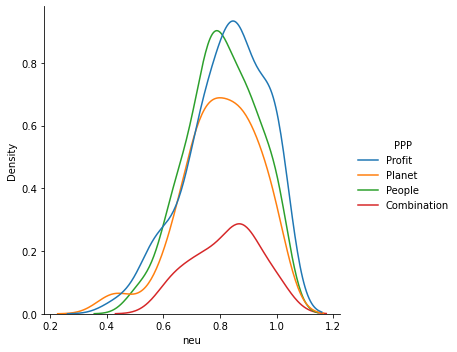

In [166]:
# Positive
import seaborn as sns
sns.displot(data=ppp_twitter, x="neu", hue='PPP', kind='kde')

### Total sentiment analysis

<Figure size 720x360 with 0 Axes>

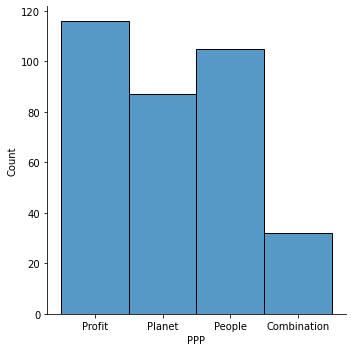

In [167]:
import seaborn as sns
plt.figure()
sns.displot(data=ppp_twitter, x='PPP')
plt.show()

<Figure size 720x360 with 0 Axes>

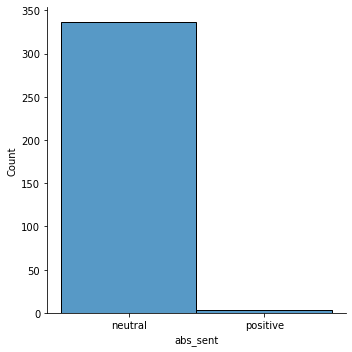

In [78]:
import seaborn as sns
plt.figure()
sns.displot(data=ppp_twitter, x='abs_sent')
plt.show()

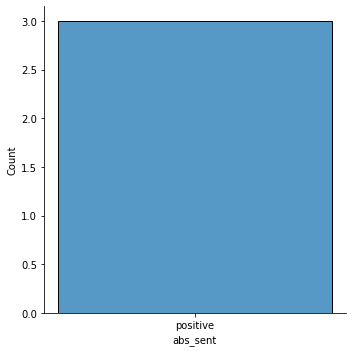

In [79]:
sns.displot(data=ppp_twitter[~ppp_twitter["abs_sent"].isin(["neutral"])], x='abs_sent')

# TODO:
1. Filter out very short tweets DONE
2. Get some nice graphs/plots (e.g. wordclouds from the tokens across all tweets, sentiment analysis summary, etc.)
3. Finish topic classification with the large dataset (i.e. port_only.csv).
   1. Maybe change the anchors
   2. Get the final topics (i.e. number of topics, keywords, etc.)
   3. Get some nice graphs (e.g. words per topic)
4. (Maybe) fancy cross-correlation plot of sentiment by topic (i.e. are "sustainable" tweets more positive or negative?)
5. Do all of the above for the large dataset (`port_only`), not the small one (`all_hashtags`).


- Wordmap -> All tweets
- Bar graph for each topic (i.e. how many topics per tweet)
- Sentiment according to topic